# Pobranie niezbędnych modułów

In [ ]:
import torch
import os
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models, utils
from torchvision.transforms import ToTensor
import numpy as np 
import matplotlib.pyplot as plt 
from cv2 import imread 
import torch.nn as nn
from torch import optim
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import random
import torch.nn.functional as F
import random
from PIL import Image
from torch.optim import lr_scheduler
import copy
import time
from sklearn.model_selection import train_test_split
plt.ion()  

# Operacje na zestawie danych

Przygotowany samodzielnie zbiór danych zamieszczony został w repozytrium projeku, z którego poniżej jest pobierany.  

https://github.com/WawrzynP/Constellation_Classification

In [ ]:
!wget https://github.com/WawrzynP/Constellation_Classification/blob/master/DataSet_JPG.zip?raw=true -O DataSet_JPG.zip

--2022-01-14 22:25:56--  https://github.com/WawrzynP/Constellation_Classification/blob/master/DataSet_JPG.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/WawrzynP/Constellation_Classification/raw/master/DataSet_JPG.zip [following]
--2022-01-14 22:25:56--  https://github.com/WawrzynP/Constellation_Classification/raw/master/DataSet_JPG.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/WawrzynP/Constellation_Classification/master/DataSet_JPG.zip [following]
--2022-01-14 22:25:57--  https://raw.githubusercontent.com/WawrzynP/Constellation_Classification/master/DataSet_JPG.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com 

In [ ]:
!unzip DataSet_JPG.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: DataSet_JPG/Lupus/img_225.jpg  
  inflating: DataSet_JPG/Lupus/img_229.jpg  
  inflating: DataSet_JPG/Lupus/img_232.jpg  
  inflating: DataSet_JPG/Lupus/img_236.jpg  
  inflating: DataSet_JPG/Lupus/img_24.jpg  
  inflating: DataSet_JPG/Lupus/img_243.jpg  
  inflating: DataSet_JPG/Lupus/img_247.jpg  
  inflating: DataSet_JPG/Lupus/img_250.jpg  
  inflating: DataSet_JPG/Lupus/img_29.jpg  
  inflating: DataSet_JPG/Lupus/img_311.jpg  
  inflating: DataSet_JPG/Lupus/img_315.jpg  
  inflating: DataSet_JPG/Lupus/img_319.jpg  
  inflating: DataSet_JPG/Lupus/img_322.jpg  
  inflating: DataSet_JPG/Lupus/img_326.jpg  
  inflating: DataSet_JPG/Lupus/img_33.jpg  
  inflating: DataSet_JPG/Lupus/img_333.jpg  
  inflating: DataSet_JPG/Lupus/img_337.jpg  
  inflating: DataSet_JPG/Lupus/img_340.jpg  
  inflating: DataSet_JPG/Lupus/img_344.jpg  
  inflating: DataSet_JPG/Lupus/img_348.jpg  
  inflating: DataSet_JPG/Lupus/img_36.

In [ ]:
directory = 'DataSet_JPG'

In [ ]:
batch_size = 32
image_size = 256

In [ ]:
transform = transforms.Compose(
  [transforms.Resize([image_size, image_size]),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
data = datasets.ImageFolder(root=directory, transform=transform)
classNames = data.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets = train_val_dataset(data)
dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = data.classes

# Funkcja trenująca
Na podstawie:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

# Funkcja rysująca wykresy

In [ ]:
def plot_acc_loss(val_acc_history, val_loss_history, train_acc_history, train_loss_history):
  val_acc_hist = []
  acc_hist = [h.cpu().numpy() for h in val_acc_history]
  train_acc_hist = []
  t_acc_hist = [h.cpu().numpy() for h in train_acc_history]
  val_loss_history
  num_epoch = 3

  plt.figure(figsize=(12, 9))
  plt.plot(
          t_acc_hist, color='green', linestyle='-', 
          label='train accuracy')

  plt.plot(
          acc_hist, color='blue', linestyle='-', 
          label='validataion accuracy')
  plt.title("Validation Accuracy")
  plt.xlabel("Training Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(12, 9))
  plt.plot(
          train_loss_history, color='orange', linestyle='-', 
          label='train loss')
  plt.plot(
          val_loss_history, color='red', linestyle='-', 
          label='validataion loss')
  plt.xlabel('Training Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Funkcja rysująca macierz błędów

In [ ]:
def conf_matrix(model, net_name):
    model.eval()
    confusion_matrix = torch.zeros(len(classNames), len(classNames))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for l, p in zip(labels.view(-1), preds.view(-1)):
              confusion_matrix[l.long(), p.long()] += 1

        plt.figure(figsize = (20,20))
        sn.heatmap(confusion_matrix, annot=True, cmap="Blues", xticklabels=classNames, yticklabels=classNames)
        plt.title('{name} \nAccuracy:{num:.3f}'.format(name=net_name, num=np.trace(confusion_matrix)/2816), fontdict={'size':'21'})
        plt.ylabel('Actual label', fontdict={'size':'18'})
        plt.xlabel('Predicted label', fontdict={'size':'18'})
        plt.show()

# ResNet50

In [ ]:
model_ft_rs50 = models.resnet50(pretrained=True)
num_ft_rs50 = model_ft_rs50.fc.in_features

model_ft_rs50.fc = nn.Linear(num_ft_rs50, len(classNames))

model_ft_rs50 = model_ft_rs50.to(device)

criterion_rs50 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_rs50 = optim.SGD(model_ft_rs50.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_rs50 = lr_scheduler.StepLR(optimizer_ft_rs50, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft_rs50, val_acc_history_rs50, val_loss_history_rs50, train_acc_history_rs50, train_loss_history_rs50 = train_model(model_ft_rs50, criterion_rs50, optimizer_ft_rs50, exp_lr_scheduler_rs50,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 4.2886 Acc: 0.0456
val Loss: 4.0302 Acc: 0.0941

Epoch 1/24
----------
train Loss: 3.4801 Acc: 0.1905
val Loss: 3.1448 Acc: 0.2379

Epoch 2/24
----------
train Loss: 2.6752 Acc: 0.3583
val Loss: 2.9269 Acc: 0.2695

Epoch 3/24
----------
train Loss: 1.9621 Acc: 0.5278
val Loss: 2.6046 Acc: 0.3263

Epoch 4/24
----------
train Loss: 1.4181 Acc: 0.6419
val Loss: 1.6736 Acc: 0.5462

Epoch 5/24
----------
train Loss: 1.0038 Acc: 0.7472
val Loss: 1.5474 Acc: 0.5692

Epoch 6/24
----------
train Loss: 0.7096 Acc: 0.8208
val Loss: 0.9477 Acc: 0.7177

Epoch 7/24
----------
train Loss: 0.4768 Acc: 0.8961
val Loss: 0.7799 Acc: 0.7642

Epoch 8/24
----------
train Loss: 0.4279 Acc: 0.9163
val Loss: 0.7626 Acc: 0.7681

Epoch 9/24
----------
train Loss: 0.4004 Acc: 0.9247
val Loss: 0.7483 Acc: 0.7720

Epoch 10/24
----------
train Loss: 0.3753 Acc: 0.9311
val Loss: 0.7406 Acc: 0.7710

Epoch 11/24
----------
train Loss: 0.3556 Acc: 0.9400
val Loss: 0.7378 Acc: 0.7741

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


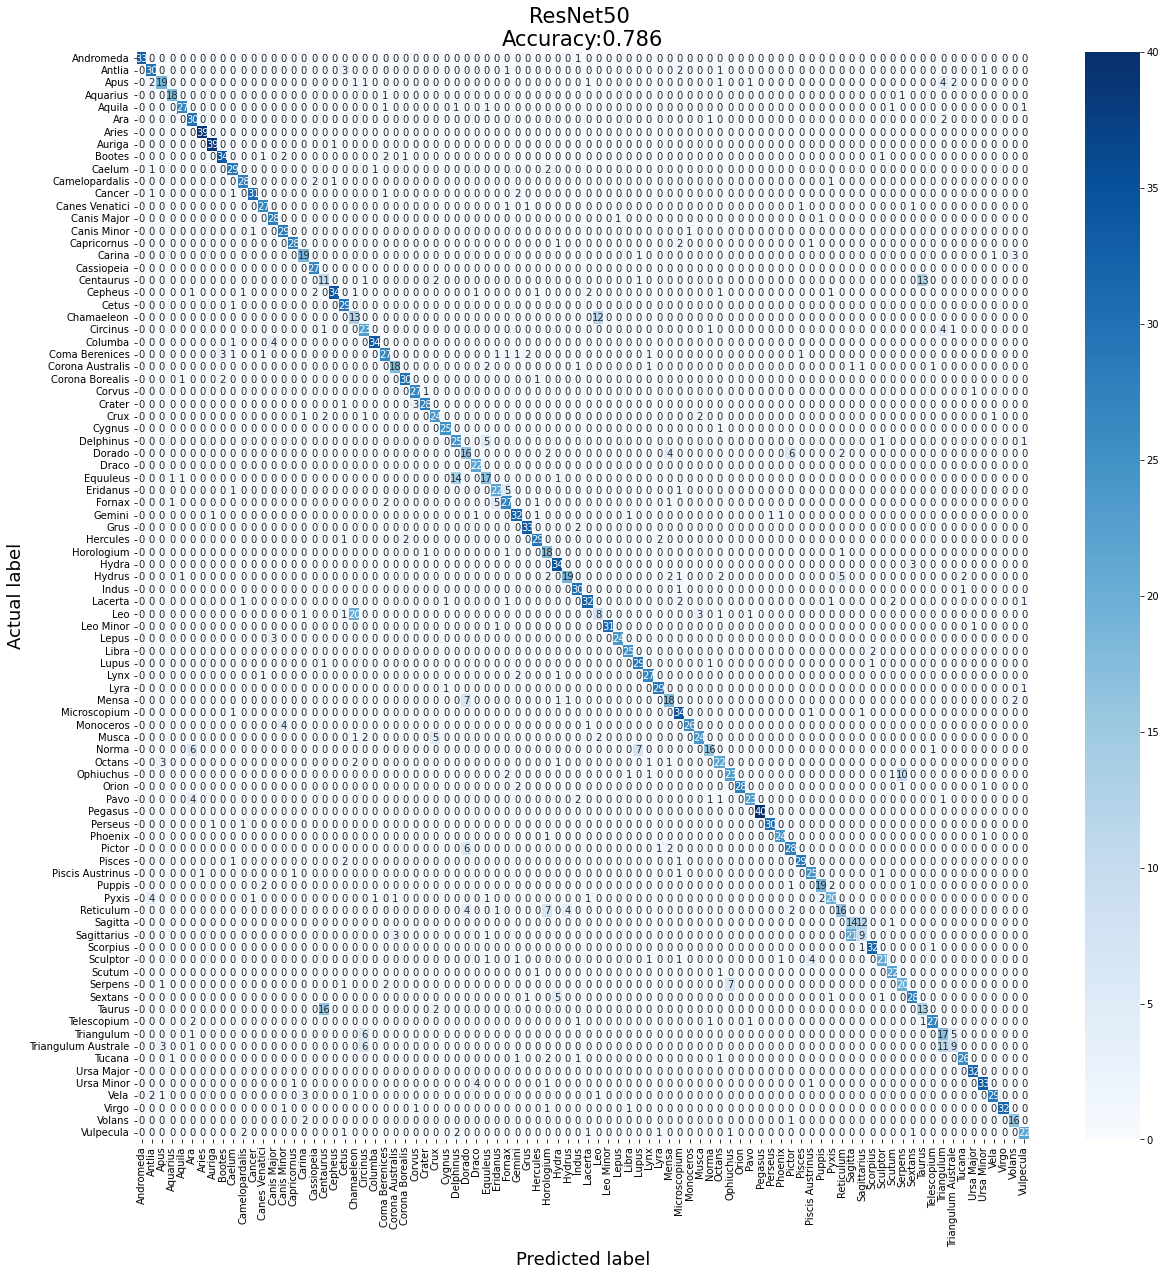

In [ ]:
conf_matrix(model_ft_rs50, 'ResNet50')

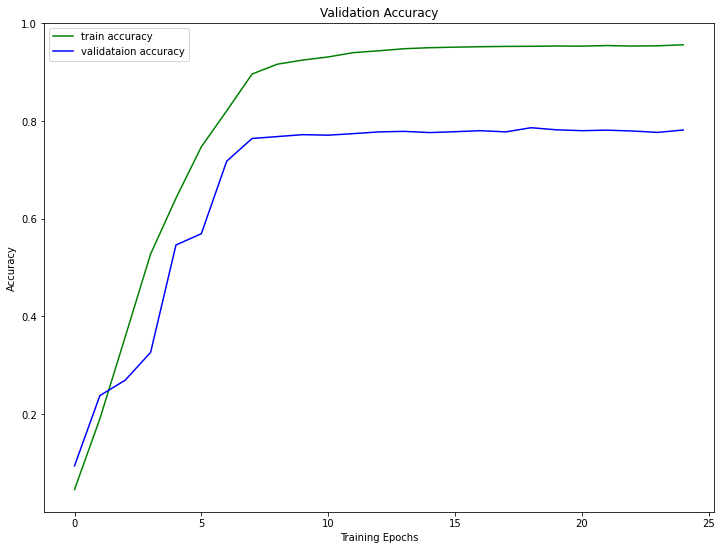

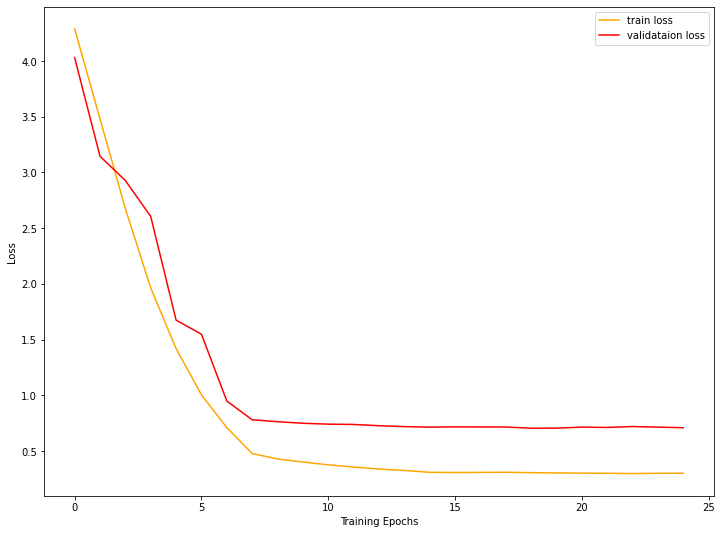

In [ ]:
plot_acc_loss(val_acc_history_rs50, val_loss_history_rs50, train_acc_history_rs50, train_loss_history_rs50)

# ResNet101

In [ ]:
model_ft_rs101 = models.resnet101(pretrained=True)
num_ft_rs101 = model_ft_rs101.fc.in_features

model_ft_rs101.fc = nn.Linear(num_ft_rs101, len(classNames))

model_ft_rs101 = model_ft_rs101.to(device)

criterion_rs101 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_rs101 = optim.SGD(model_ft_rs101.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_rs101 = lr_scheduler.StepLR(optimizer_ft_rs101, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
model_ft_rs101, val_acc_history_rs101, val_loss_history_rs101, train_acc_history_rs101, train_loss_history_rs101= train_model(model_ft_rs101, criterion_rs101, optimizer_ft_rs101, exp_lr_scheduler_rs101,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 4.2459 Acc: 0.0497
val Loss: 3.8587 Acc: 0.0959

Epoch 1/24
----------
train Loss: 3.3530 Acc: 0.2000
val Loss: 3.1849 Acc: 0.2099

Epoch 2/24
----------
train Loss: 2.4340 Acc: 0.4044
val Loss: 2.3201 Acc: 0.4130

Epoch 3/24
----------
train Loss: 1.6700 Acc: 0.5908
val Loss: 1.8145 Acc: 0.5210

Epoch 4/24
----------
train Loss: 1.1067 Acc: 0.7144
val Loss: 1.5308 Acc: 0.5969

Epoch 5/24
----------
train Loss: 0.7265 Acc: 0.8149
val Loss: 1.3640 Acc: 0.6019

Epoch 6/24
----------
train Loss: 0.4740 Acc: 0.8769
val Loss: 1.0514 Acc: 0.6800

Epoch 7/24
----------
train Loss: 0.2812 Acc: 0.9451
val Loss: 0.6368 Acc: 0.8011

Epoch 8/24
----------
train Loss: 0.2338 Acc: 0.9613
val Loss: 0.6218 Acc: 0.8018

Epoch 9/24
----------
train Loss: 0.2145 Acc: 0.9674
val Loss: 0.6100 Acc: 0.8047

Epoch 10/24
----------
train Loss: 0.1966 Acc: 0.9701
val Loss: 0.6050 Acc: 0.8079

Epoch 11/24
----------
train Loss: 0.1879 Acc: 0.9727
val Loss: 0.6039 Acc: 0.8089

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


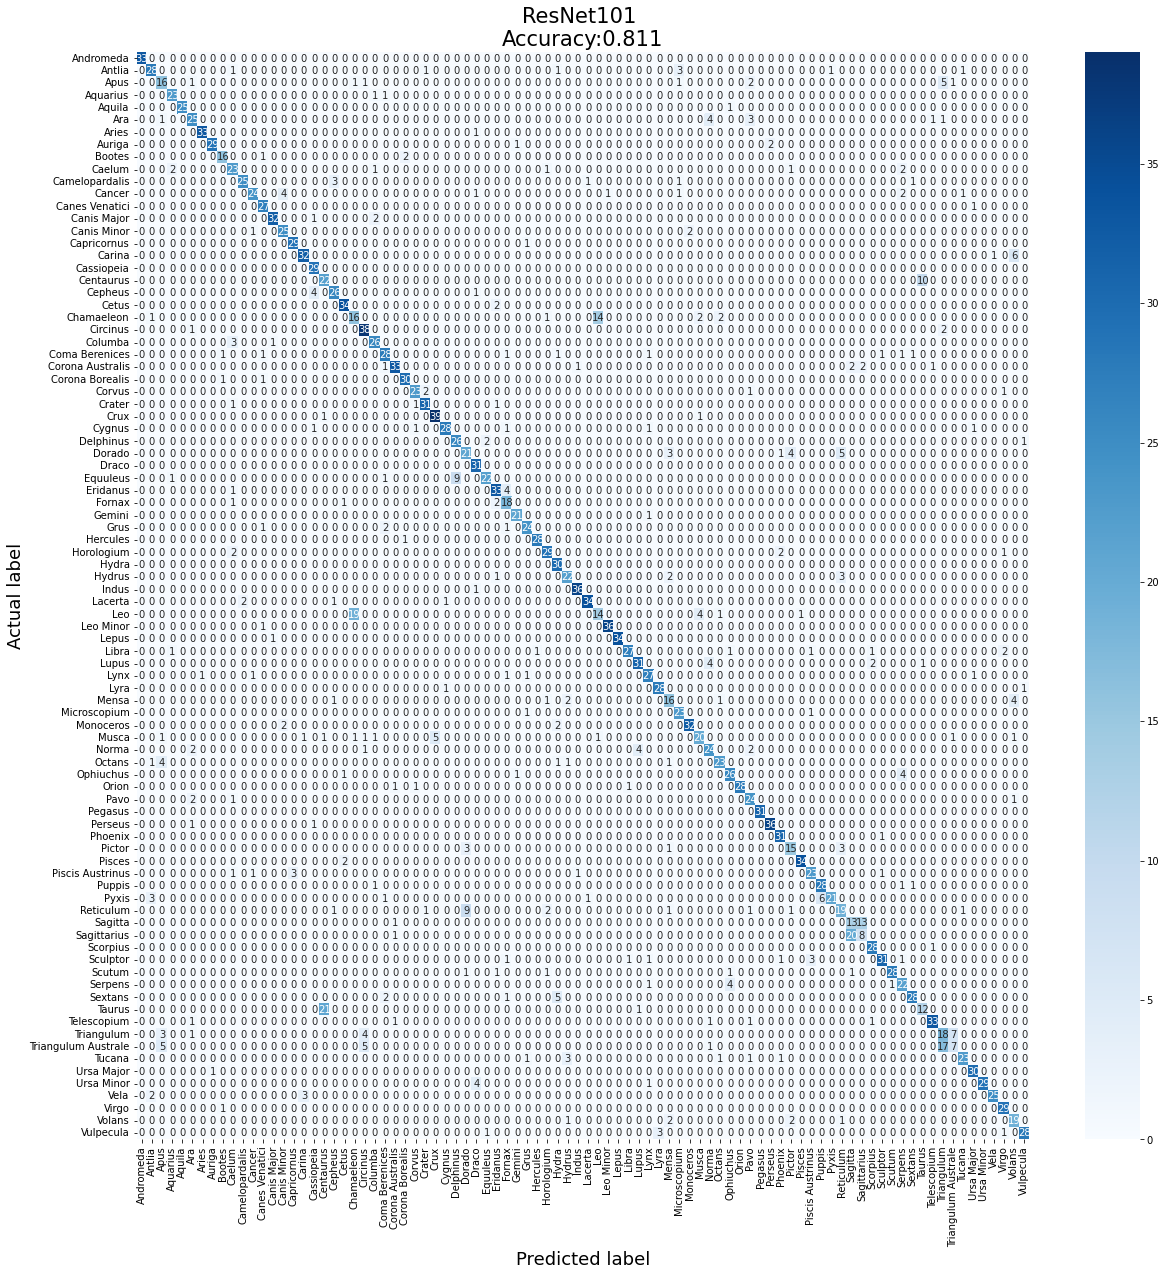

In [ ]:
conf_matrix(model_ft_rs101, 'ResNet101')

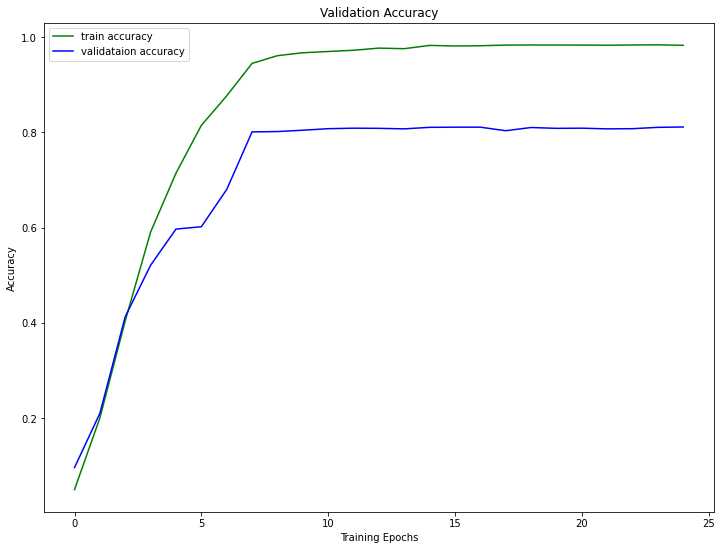

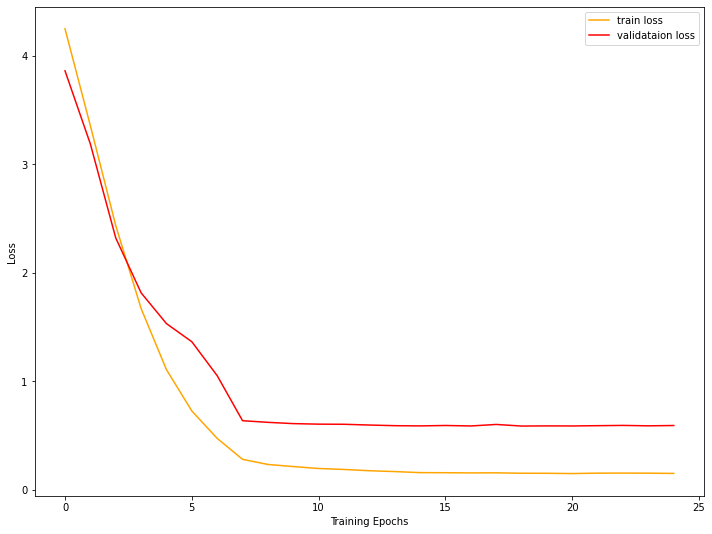

In [ ]:
plot_acc_loss(val_acc_history_rs101, val_loss_history_rs101, train_acc_history_rs101, train_loss_history_rs101)

# Densenet121

In [ ]:
model_ft_ds121 = models.densenet121(pretrained=True)
num_ft_ds121 = model_ft_ds121.classifier.in_features
model_ft_ds121.classifier = nn.Linear(num_ft_ds121, len(classNames))

model_ft_ds121 = model_ft_ds121.to(device)
criterion_ds121 = nn.CrossEntropyLoss()
optimizer_ft_ds121 = optim.SGD(model_ft_ds121.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_ds121 = lr_scheduler.StepLR(optimizer_ft_ds121, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
model_ft_ds121, val_acc_history_ds121, val_loss_history_ds121, train_acc_history_ds121, train_loss_history_ds121= train_model(model_ft_ds121, criterion_ds121, optimizer_ft_ds121, exp_lr_scheduler_ds121,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 4.3581 Acc: 0.0379
val Loss: 4.0975 Acc: 0.0675

Epoch 1/24
----------
train Loss: 3.5864 Acc: 0.1741
val Loss: 3.2155 Acc: 0.2290

Epoch 2/24
----------
train Loss: 2.7526 Acc: 0.3512
val Loss: 2.6299 Acc: 0.3736

Epoch 3/24
----------
train Loss: 2.0645 Acc: 0.5026
val Loss: 2.3027 Acc: 0.4162

Epoch 4/24
----------
train Loss: 1.5375 Acc: 0.6165
val Loss: 1.6802 Acc: 0.5522

Epoch 5/24
----------
train Loss: 1.1569 Acc: 0.7049
val Loss: 1.4820 Acc: 0.5913

Epoch 6/24
----------
train Loss: 0.8577 Acc: 0.7830
val Loss: 1.1317 Acc: 0.6783

Epoch 7/24
----------
train Loss: 0.5996 Acc: 0.8675
val Loss: 0.8147 Acc: 0.7514

Epoch 8/24
----------
train Loss: 0.5437 Acc: 0.8836
val Loss: 0.7940 Acc: 0.7553

Epoch 9/24
----------
train Loss: 0.5071 Acc: 0.8935
val Loss: 0.7757 Acc: 0.7631

Epoch 10/24
----------
train Loss: 0.4830 Acc: 0.9025
val Loss: 0.7556 Acc: 0.7685

Epoch 11/24
----------
train Loss: 0.4579 Acc: 0.9093
val Loss: 0.7465 Acc: 0.7717

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


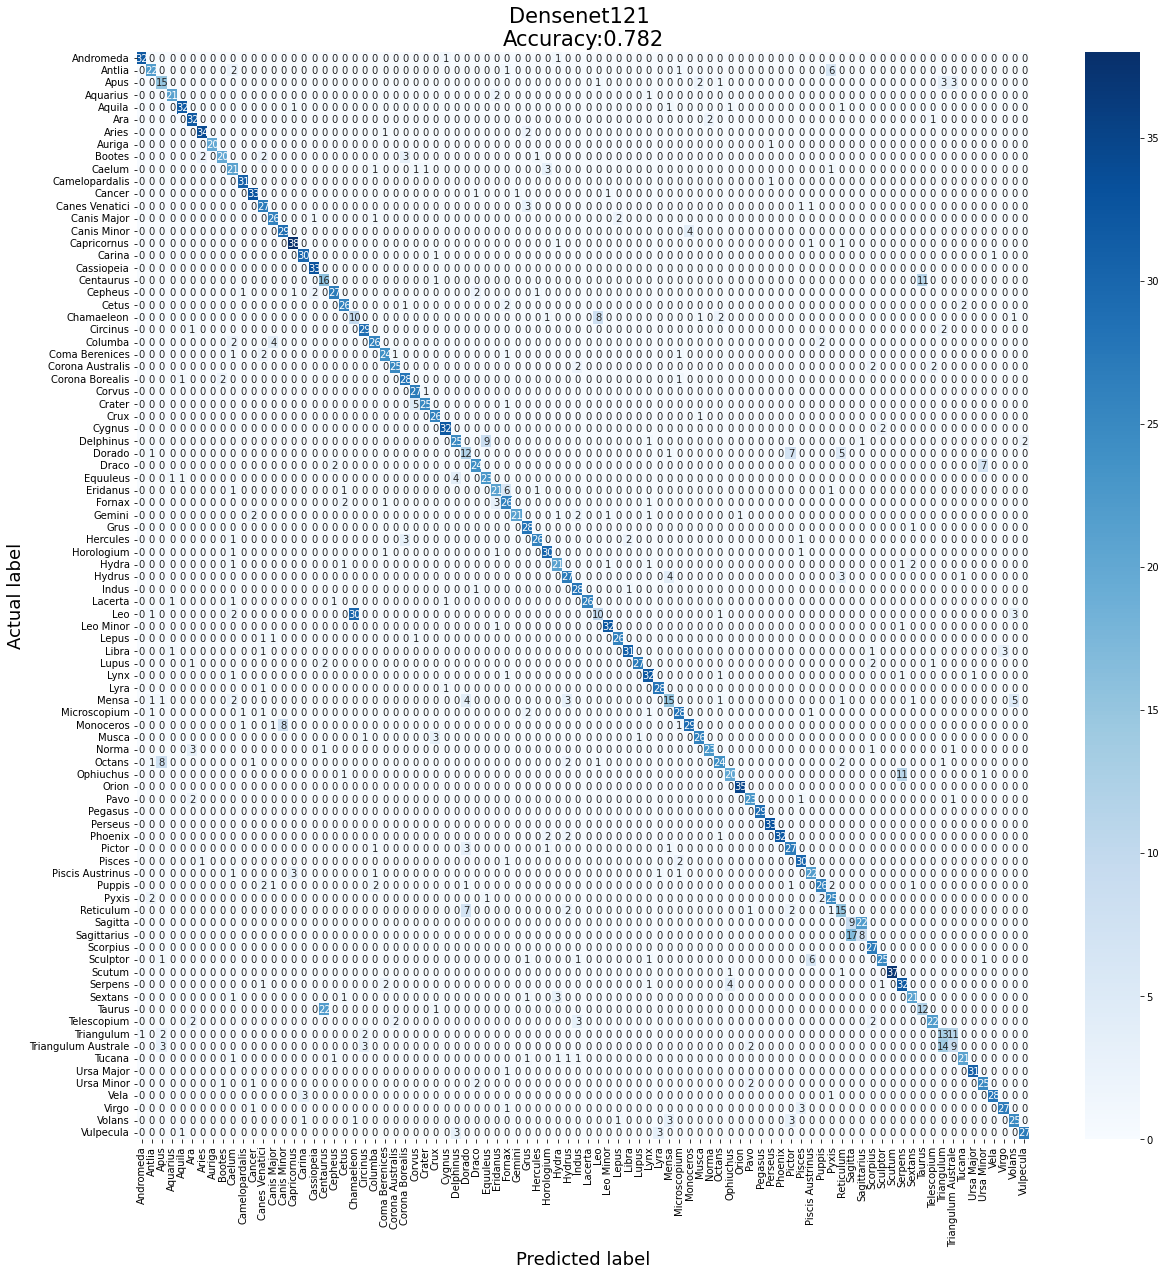

In [ ]:
conf_matrix(model_ft_ds121, 'Densenet121')

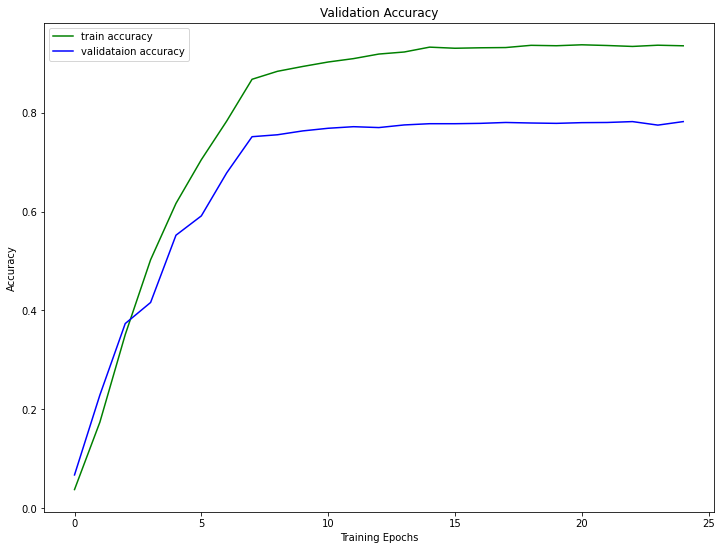

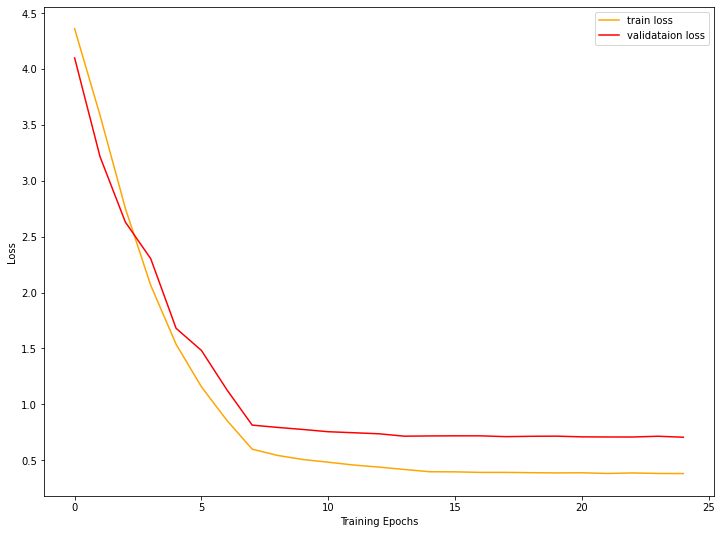

In [ ]:
Jakplot_acc_loss(val_acc_history_ds121, val_loss_history_ds121, train_acc_history_ds121, train_loss_history_ds121)